# Preprocess extra host data

In [1]:
import polars as pl

host_preds_df = pl.read_csv('relabeled_datasets/train_host_extra.csv')
host_preds_df.head()

SMILES,Tg,FFV,Tc,Density,Rg
str,f64,f64,f64,f64,f64
"""*Oc1ccc(/N=C/C=N/c2ccc(OC(=O)N…",98.638333,0.354566,0.237436,1.06817,16.479541
"""*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F…",10.916464,0.31897,0.102049,1.226474,15.589463
"""*CCCCOC(=O)CCCCCCCC(=O)O*""",-23.218988,0.352278,0.259469,0.993399,20.42647
"""*CCCCCCCCCCc1ccc(-c2c(-c3ccccc…",177.048613,0.399035,0.334328,0.927258,21.333276
"""*c1ccc(-c2ccc(-c3sc(*)c(CCCCCC…",37.73761,0.427989,0.360618,0.959014,17.871737


In [2]:
host_labels_df = pl.read_csv('../data/from_host_v2/train_host_extra.csv')
host_labels_df.head()

SMILES,Tg,FFV,Tc,Density,Rg
str,str,f64,f64,str,str
"""*Oc1ccc(/N=C/C=N/c2ccc(OC(=O)N…",null,null,0.349,null,null
"""*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F…",null,0.320846,0.109,null,null
"""*CCCCOC(=O)CCCCCCCC(=O)O*""",null,null,0.241,null,null
"""*CCCCCCCCCCc1ccc(-c2c(-c3ccccc…",null,0.398266,0.21,null,null
"""*c1ccc(-c2ccc(-c3sc(*)c(CCCCCC…",null,null,0.299,null,null


Baseline MAE: 43.112283711331436
Scaled MAE: 32.26024130296122


SMILES,Tg_label,Tg_pred,Tg_rescaled_label
str,f64,f64,f64
"""*CCCCCCCOc1ccc(C=CC=Cc2ccc(O*)…",41.892701,31.151999,53.256676
"""*Oc1c([2H])c([2H])c(C(c2c([2H]…",230.991382,224.504121,207.367656
"""*OS(=O)(=O)c1ccc(S(=O)(=O)c2cc…",194.267801,187.078085,170.25567
"""*Oc1ccc(C(C)(CCCC)c2ccc(OC(*)=…",118.836135,62.397579,107.700228
"""*Cc1cc(C=O)c(O)c(Cc2cc(C=O)c(O…",190.607215,132.58481,169.704697


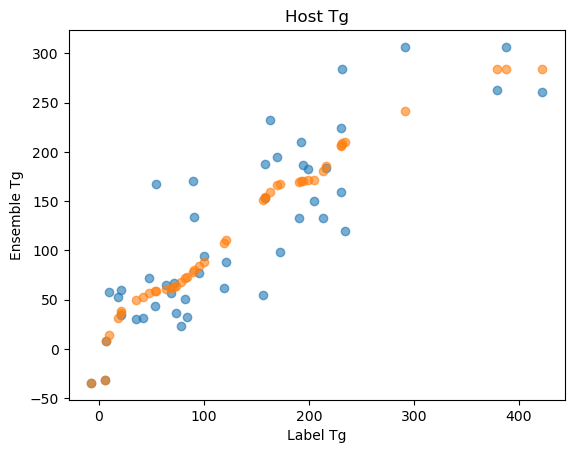

In [3]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from cir_model import CenteredIsotonicRegression

TARGET_NAME = 'Tg'

temp_df = (
    host_labels_df
    .drop_nulls(subset=TARGET_NAME)
    .join(host_preds_df, on='SMILES', how='inner')
    .with_columns(
        pl.col(TARGET_NAME).alias(f'{TARGET_NAME}_label').cast(float),
        pl.col(f'{TARGET_NAME}_right').alias(f'{TARGET_NAME}_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/host_extra.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'Host {TARGET_NAME}')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

Baseline MAE: 0.003591625690601788
Scaled MAE: 0.003240232967570245


SMILES,FFV_label,FFV_pred,FFV_rescaled_label
str,f64,f64,f64
"""*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F…",0.320846,0.31897,0.31897
"""*CCCCCCCCCCc1ccc(-c2c(-c3ccccc…",0.398266,0.399035,0.399035
"""*c1ccc2c(c1)C(=O)N(c1ccc(Oc3cc…",0.383268,0.380563,0.382231
"""*CC(*)C(=O)N1CCCCC1""",0.368285,0.373906,0.368699
"""*CCCCOC(=O)c1ccc(-c2ccc(C(=O)O…",0.339303,0.342882,0.340133


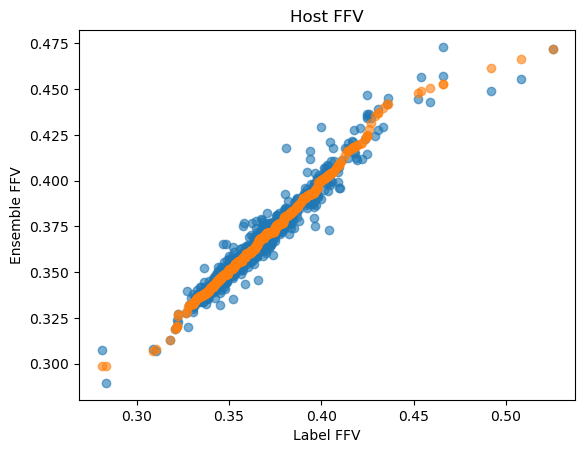

In [4]:
TARGET_NAME = 'FFV'

temp_df = (
    host_labels_df
    .drop_nulls(subset=TARGET_NAME)
    .join(host_preds_df, on='SMILES', how='inner')
    .with_columns(
        pl.col(TARGET_NAME).alias(f'{TARGET_NAME}_label').cast(float),
        pl.col(f'{TARGET_NAME}_right').alias(f'{TARGET_NAME}_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/host_extra.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'Host {TARGET_NAME}')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

Baseline MAE: 0.05680430633804307
Scaled MAE: 0.033547348031150205


SMILES,Tc_label,Tc_pred,Tc_rescaled_label
str,f64,f64,f64
"""*Oc1ccc(/N=C/C=N/c2ccc(OC(=O)N…",0.349,0.237436,0.300499
"""*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F…",0.109,0.102049,0.147739
"""*CCCCOC(=O)CCCCCCCC(=O)O*""",0.241,0.259469,0.243024
"""*CCCCCCCCCCc1ccc(-c2c(-c3ccccc…",0.21,0.334328,0.231608
"""*c1ccc(-c2ccc(-c3sc(*)c(CCCCCC…",0.299,0.360618,0.272314


statistic,SMILES,Tc_label,Tc_pred,Tc_rescaled_label
str,str,f64,f64,f64
"""count""","""129""",129.0,129.0,129.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,0.258497,0.238873,0.238228
"""std""",null,0.152331,0.063861,0.047238
"""min""","""*/C(=C(\c1ccccc1)c1ccc(*)cc1)c…",0.091,0.090226,0.1212
"""25%""",null,0.198,0.203183,0.22794
"""50%""",null,0.235,0.234857,0.238916
"""75%""",null,0.294,0.273305,0.268378
"""max""","""*c1sc(-c2cc(CCCCCCCCCC)c(*)s2)…",1.59,0.40285,0.308254


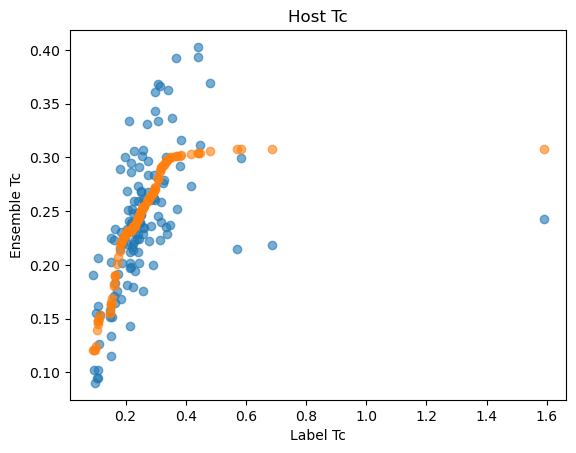

In [10]:
TARGET_NAME = 'Tc'

temp_df = (
    host_labels_df
    .drop_nulls(subset=TARGET_NAME)
    .join(host_preds_df, on='SMILES', how='inner')
    .with_columns(
        pl.col(TARGET_NAME).alias(f'{TARGET_NAME}_label').cast(float),
        pl.col(f'{TARGET_NAME}_right').alias(f'{TARGET_NAME}_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())
display(temp_df.describe())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/host_extra.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'Host {TARGET_NAME}')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

# Preprocess natsume data

In [6]:
import polars as pl

natsume_tc_labels_df = pl.read_csv('../data/from_natsume/Tc_SMILES.csv')
natsume_tc_labels_df = natsume_tc_labels_df.with_columns(pl.col('TC_mean').alias('Tc'))
display(natsume_tc_labels_df.head())

leak_preds_df = pl.read_csv('relabeled_datasets/train_tc-natsume_full-dmitry_extra.csv')
leak_preds_df.head()

TC_mean,SMILES,Tc
f64,str,f64
0.2445,"""*CC(*)C""",0.2445
0.225333,"""*CC(*)CC""",0.225333
0.246333,"""*CC(*)CCC""",0.246333
0.1868,"""*CC(*)C(C)C""",0.1868
0.230667,"""*CC(*)CCCC""",0.230667


SMILES,Tg,FFV,Tc,Density,Rg
str,f64,f64,f64,f64,f64
"""Cc1ccc(NC=S)cc1""",105.167213,0.380059,0.240362,1.042567,18.103305
"""FC(F)(F)C(Cl)Cl""",29.901081,0.363941,0.153756,1.211909,19.860019
"""*CCC(C)(C)CC(C)CNC(=O)CCCCC(=O…",51.473217,0.341021,0.259974,0.9412,16.146797
"""*c1ccc(-c2ccc(-c3ccc(C(*)c4c(F…",254.86534,0.401851,0.200267,1.100275,23.191832
"""c1ccc(C2=C(c3ccccc3)CCCC2)cc1""",136.242006,0.390639,0.230768,0.94446,15.615252


In [7]:
from rdkit import Chem

def canonicalize_smiles(smiles: str) -> str:
    molecule = Chem.MolFromSmiles(smiles)
    return Chem.MolToSmiles(molecule, canonical=True) if molecule is not None else None

natsume_tc_labels_df = natsume_tc_labels_df.with_columns(
    pl.col("SMILES").map_elements(canonicalize_smiles).alias("SMILES")
)
natsume_tc_labels_df.head()

/tmp/ipykernel_904089/4104964660.py:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  natsume_tc_labels_df = natsume_tc_labels_df.with_columns(


TC_mean,SMILES,Tc
f64,str,f64
0.2445,"""*CC(*)C""",0.2445
0.225333,"""*CC(*)CC""",0.225333
0.246333,"""*CC(*)CCC""",0.246333
0.1868,"""*CC(*)C(C)C""",0.1868
0.230667,"""*CC(*)CCCC""",0.230667


Baseline MAE: 0.056629214006550306
Scaled MAE: 0.03343801224327203


SMILES,Tc_label,Tc_pred,Tc_rescaled_label
str,f64,f64,f64
"""*c1ccc(-c2ccc(-c3ccc(C(*)c4c(F…",0.291,0.200267,0.267076
"""*CCCCCc1ccc(CCCCCOC(=O)c2ccc(C…",0.276,0.267677,0.261111
"""*c1ccc(Oc2ccc(-c3csc(/N=C/c4cc…",0.253,0.301362,0.250863
"""*CCCCCCCCCCCCCCOC(=O)c1ccc(C(=…",0.258,0.307025,0.253691
"""*CCCc1ccc(CCCOC(=O)c2ccc(C(=O)…",0.249,0.238481,0.248221


statistic,SMILES,Tc_label,Tc_pred,Tc_rescaled_label
str,str,f64,f64,f64
"""count""","""130""",130.0,130.0,130.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,0.257701,0.238527,0.237872
"""std""",null,0.152011,0.063733,0.047266
"""min""","""*/C(=C(\c1ccccc1)c1ccc(*)cc1)c…",0.091,0.090177,0.121343
"""25%""",null,0.194,0.202366,0.226692
"""50%""",null,0.235,0.235398,0.23893
"""75%""",null,0.294,0.273475,0.268259
"""max""","""*c1sc(-c2cc(CCCCCCCCCC)c(*)s2)…",1.59,0.4028,0.30838


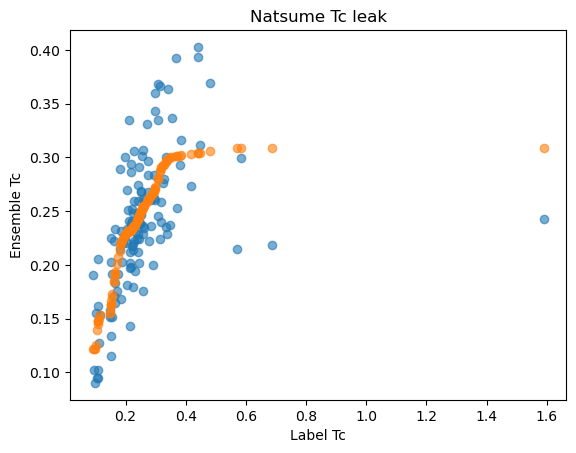

In [11]:
import matplotlib.pyplot as plt

TARGET_NAME = 'Tc'

temp_df = (
    natsume_tc_labels_df
    .join(leak_preds_df, on='SMILES', how='inner')
    .with_columns(
        pl.col('Tc').alias('Tc_label'),
        pl.col('Tc_right').alias('Tc_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())
display(temp_df.describe())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/natsume.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'Natsume {TARGET_NAME} leak')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

# Preprocess dmitry

In [14]:
import pandas as pd

# https://springernature.figshare.com/articles/dataset/dataset_with_glass_transition_temperature/24219958?file=42507037
data_tg2 = pd.read_csv('../data/from_dmitry/archive/JCIM_sup_bigsmiles.csv', usecols=['SMILES', 'Tg (C)'])
data_tg2['SMILES'] = data_tg2['SMILES'].apply(lambda s: canonicalize_smiles(s))
data_tg2 = data_tg2.rename(columns={'Tg (C)': 'Tg'})

# https://www.sciencedirect.com/science/article/pii/S2590159123000377#ec0005
data_tg3 = pd.read_excel('../data/from_dmitry/archive/data_tg3.xlsx')
data_tg3['SMILES'] = data_tg3['SMILES'].apply(lambda s: canonicalize_smiles(s))
data_tg3 = data_tg3.rename(columns={'Tg [K]': 'Tg'})
data_tg3['Tg'] = data_tg3['Tg'] - 273.15

# https://github.com/Duke-MatSci/ChemProps
data_density = pd.read_excel('../data/from_dmitry/archive/data_dnst1.xlsx')
data_density = data_density.rename(columns={'density(g/cm3)': 'Density'})[['SMILES', 'Density']]
data_density['SMILES'] = data_density['SMILES'].apply(lambda s: canonicalize_smiles(s))
data_density = data_density[(data_density['SMILES'].notnull())&(data_density['Density'].notnull())&(data_density['Density'] != 'nylon')]
data_density['Density'] = data_density['Density'].astype('float64')
data_density['Density'] -= 0.118

data_tg2 = pl.from_pandas(data_tg2)
data_tg3 = pl.from_pandas(data_tg3)
data_density = pl.from_pandas(data_density)

[23:05:23] SMILES Parse Error: syntax error while parsing: *O[Si](*)([R])[R]
[23:05:23] SMILES Parse Error: check for mistakes around position 12:
[23:05:23] *O[Si](*)([R])[R]
[23:05:23] ~~~~~~~~~~~^
[23:05:23] SMILES Parse Error: Failed parsing SMILES '*O[Si](*)([R])[R]' for input: '*O[Si](*)([R])[R]'
[23:05:23] SMILES Parse Error: syntax error while parsing: *NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4
[23:05:23] SMILES Parse Error: check for mistakes around position 28:
[23:05:23] c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=
[23:05:23] ~~~~~~~~~~~~~~~~~~~~^
[23:05:23] SMILES Parse Error: Failed parsing SMILES '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4' for input: '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4'
[23:05:23] SMILES Parse Error: syntax error while parsing: O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[23:05:23] SMILES Parse Error: check for mistakes around position 7:
[23:05:23] O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[23:05:23] ~~~~~~^
[23:05:23] SMILES Parse Error: F

Baseline MAE: 51.84548598953437
Scaled MAE: 35.758863683862195


SMILES,Tg_label,Tg_pred,Tg_rescaled_label
str,f64,f64,f64
"""*CCC(C)(C)CC(C)CNC(=O)CCCCC(=O…",54.82,51.473217,47.219869
"""*CCCCc1nc2cc(NC(=NO)C(=NO)Nc3c…",170.113033,194.666614,129.549034
"""*CCC(C)Oc1ccc(-c2ccc(C(=O)OCC(…",116.96,62.92224,80.322426
"""*Nc1ccc(NC(=O)c2cc(NC(=O)C(CCS…",230.319156,158.832456,180.371793
"""*CC(CCCCCCOc1ccc(-c2ccc(C#N)cc…",78.110617,24.24571,59.679507


statistic,SMILES,Tg_label,Tg_pred,Tg_rescaled_label
str,str,f64,f64,f64
"""count""","""145""",145.0,145.0,145.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,151.917982,119.200561,119.631401
"""std""",null,110.765553,94.333252,85.210009
"""min""","""*=Nc1ccc(N=C(C)Nc2ccc(-c3ccc(N…",-36.93,-34.332942,-1.338085
"""25%""",null,62.4,43.096589,52.043412
"""50%""",null,139.73,94.55425,99.068411
"""75%""",null,230.319156,187.463786,180.371793
"""max""","""*c1sc(*)c2sc(CCCCCCCCC)nc12""",442.63,374.503788,319.406258


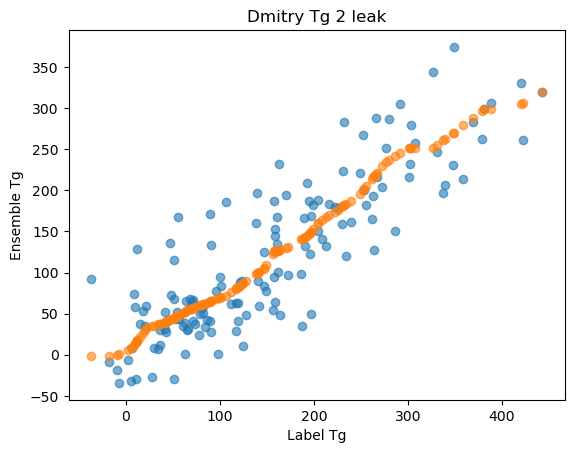

In [17]:
import matplotlib.pyplot as plt

TARGET_NAME = 'Tg'

temp_df = (
    data_tg2
    .join(leak_preds_df, on='SMILES', how='inner')
    .with_columns(
        pl.col(TARGET_NAME).alias(f'{TARGET_NAME}_label'),
        pl.col(f'{TARGET_NAME}_right').alias(f'{TARGET_NAME}_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())
display(temp_df.describe())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/dmitry_2.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'Dmitry {TARGET_NAME} 2 leak')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

Baseline MAE: 130.68894918009266
Scaled MAE: 32.989216317978936


SMILES,Tg_label,Tg_pred,Tg_rescaled_label
str,f64,f64,f64
"""FC(F)(F)C(Cl)Cl""",-214.15,29.901081,44.839975
"""c1ccc(C2=C(c3ccccc3)CCCC2)cc1""",-43.15,136.242006,92.419767
"""CCCC(C)C(O)CC""",-110.95,46.77772,65.408246
"""Cn1c(=O)c2c(ncn2C)n(C)c1=O""",-13.15,175.30104,99.251023
"""CNc1nc(Nc2cc(C(C)(C)C)cc(C(C)(…",129.0,183.093317,199.187386


statistic,SMILES,Tg_label,Tg_pred,Tg_rescaled_label
str,str,f64,f64,f64
"""count""","""501""",501.0,501.0,501.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,-19.676527,110.036403,109.424613
"""std""",null,94.389545,60.919282,46.17813
"""min""","""Brc1cc2ccccc2c2ccccc12""",-255.15,-15.128603,28.341301
"""25%""",null,-102.75,68.031166,69.153437
"""50%""",null,8.85,100.013957,100.308329
"""75%""",null,55.0,145.764995,145.733661
"""max""","""c1ccncc1""",177.8,343.832477,333.32804


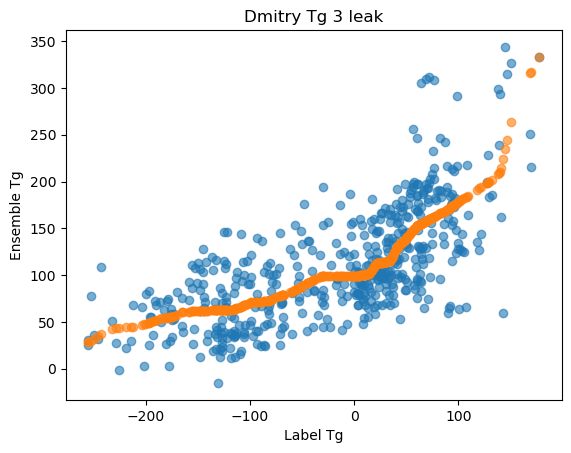

In [18]:
import matplotlib.pyplot as plt

TARGET_NAME = 'Tg'

temp_df = (
    data_tg3
    .join(leak_preds_df, on='SMILES', how='inner')
    .with_columns(
        pl.col(TARGET_NAME).alias(f'{TARGET_NAME}_label'),
        pl.col(f'{TARGET_NAME}_right').alias(f'{TARGET_NAME}_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())
display(temp_df.describe())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/dmitry_3.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'Dmitry {TARGET_NAME} 3 leak')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

Baseline MAE: 0.148049247513765
Scaled MAE: 0.0499067573568016


SMILES,Density_label,Density_pred,Density_rescaled_label
str,f64,f64,f64
"""Cc1ccc(NC=S)cc1""",1.342,1.042567,1.101652
"""*CC(*)OC(C)=O""",1.102,1.017499,1.054599
"""*CC1CC(*)OC(CCC)O1""",0.952,0.940187,0.985073
"""*OC(=O)Oc1ccc(C2(c3ccc(*)cc3)C…",1.052,1.065816,1.047092
"""OC(=S)Oc1ccccc1""",0.922,1.126784,0.955658


statistic,SMILES,Density_label,Density_pred,Density_rescaled_label
str,str,f64,f64,f64
"""count""","""536""",536.0,536.0,536.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,1.181931,1.065255,1.066205
"""std""",null,0.223176,0.114357,0.093328
"""min""","""*.*C/C=C/CC.*CC(*)C#N.*CCC(C*)…",0.752,0.769582,0.812201
"""25%""",null,1.002,1.006854,1.015517
"""50%""",null,1.162,1.066891,1.08862
"""75%""",null,1.342,1.124736,1.101652
"""max""","""c1csc(-c2cccs2)c1""",1.982,1.773845,1.587281


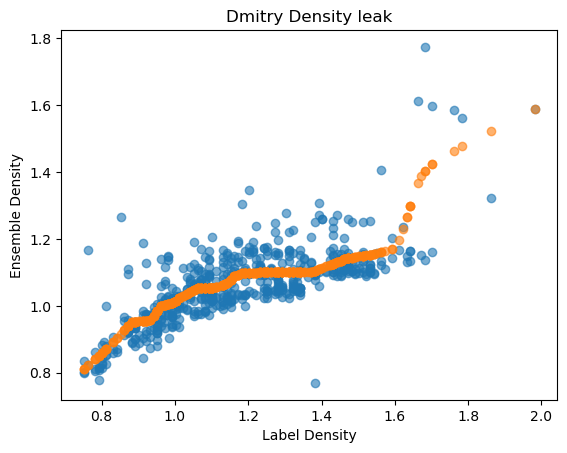

In [20]:
import matplotlib.pyplot as plt

TARGET_NAME = 'Density'

temp_df = (
    data_density
    .join(leak_preds_df, on='SMILES', how='inner')
    .with_columns(
        pl.col(TARGET_NAME).alias(f'{TARGET_NAME}_label'),
        pl.col(f'{TARGET_NAME}_right').alias(f'{TARGET_NAME}_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())
display(temp_df.describe())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/dmitry.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'Dmitry {TARGET_NAME} leak')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

# Preprocess RadonPy data

In [26]:
import pandas as pd

radonpy_labels_df = pl.from_pandas(pd.read_csv('../data/RadonPy/data/PI1070.csv'))
radonpy_labels_df.head()

monomer_ID,SMILES,mol_weight_monomer,atomic_weight_mean,vdw_volume_monomer,qm_total_energy_monomer,qm_homo_monomer,qm_lumo_monomer,qm_dipole_monomer,qm_dipole_x_monomer,qm_dipole_y_monomer,qm_dipole_z_monomer,qm_polarizability_monomer,qm_polarizability_xx_monomer,qm_polarizability_yy_monomer,qm_polarizability_zz_monomer,qm_polarizability_xy_monomer,qm_polarizability_xz_monomer,qm_polarizability_yz_monomer,temp,press,tacticity,DP,n_mol,n_atom_mean,Mn,density,density_min,density_max,density_std,density_count,Rg,Rg_min,Rg_max,Rg_std,Rg_count,r2,…,TC_ke_count,TC_pe,TC_pe_min,TC_pe_max,TC_pe_std,TC_pe_count,TC_pair,TC_pair_min,TC_pair_max,TC_pair_std,TC_pair_count,TC_bond,TC_bond_min,TC_bond_max,TC_bond_std,TC_bond_count,TC_angle,TC_angle_min,TC_angle_max,TC_angle_std,TC_angle_count,TC_dihed,TC_dihed_min,TC_dihed_max,TC_dihed_std,TC_dihed_count,TC_improper,TC_improper_min,TC_improper_max,TC_improper_std,TC_improper_count,TC_kspace,TC_kspace_min,TC_kspace_max,TC_kspace_std,TC_kspace_count,polymer_class
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""PI1""","""*CC*""",28.054,4.675667,45.008,-209676.7175,-12.037272,3.128817,0.000009,0.000006,-0.000006,-0.000004,3.984521,4.240288,3.854861,3.858414,0.028186,0.046852,0.00339,300,1,"""none""",165,10,998,4658.98,0.837972,0.835574,0.8398,0.001777,5,22.52883,21.149623,24.449113,1.310073,5,27.084269,…,5.0,0.014002,0.007976,0.020837,0.004815,5.0,0.092199,0.081823,0.104619,0.009062,5.0,0.098619,0.071217,0.145977,0.028407,5.0,0.210823,0.190444,0.236648,0.017101,5.0,0.01151,0.00774,0.021453,0.005759,5.0,0.0,0.0,0.0,0.0,5.0,0.0000138,-0.000028,0.0000293,0.0000241,5.0,1
"""PI2""","""*C(C*)C""",42.081,4.675667,61.624,-312948.9242,-11.576865,3.039961,0.077278,0.00398,0.032282,0.070099,5.780308,6.281963,5.435921,5.623038,0.034819,-0.050907,0.105224,300,1,"""atactic""",110,10,998,4658.98,0.835732,0.833629,0.837995,0.001856,5,18.304217,16.982181,20.015614,1.393047,5,18.550886,…,5.0,0.001013,-0.003554,0.003963,0.002833,5.0,0.076148,0.066997,0.084563,0.00713,5.0,0.061317,0.050411,0.08191,0.01364,5.0,0.102626,0.086521,0.118947,0.012555,5.0,0.002962,0.000382,0.005652,0.002022,5.0,0.0,0.0,0.0,0.0,5.0,0.000279,-0.000165,0.000562,0.000302,5.0,1
"""PI3""","""*C(C*)CC""",56.108,4.675667,78.424,-416219.2389,-11.423908,2.987135,0.081852,-0.003192,-0.04659,-0.067223,7.514826,8.191657,7.119034,7.233788,-0.092424,0.024052,0.163036,300,1,"""atactic""",83,10,1004,4687.034,0.833803,0.828961,0.838093,0.003371,5,17.610296,16.585106,18.849661,0.911022,5,14.65166,…,5.0,0.009875,0.002627,0.012907,0.004115,5.0,0.087928,0.081069,0.09945,0.007506,5.0,0.058446,0.044494,0.077881,0.012535,5.0,0.08904,0.077136,0.099661,0.008326,5.0,0.002048,0.000441,0.004382,0.001483,5.0,0.0,0.0,0.0,0.0,5.0,0.0000586,-0.000043,0.000288,0.000133,5.0,1
"""PI4""","""*C(C*)CCC""",70.135,4.675667,95.392,-519493.419,-11.227201,3.052917,0.075347,0.00363,-0.063107,-0.041006,9.363666,10.883658,8.726422,8.480916,0.139907,-0.03872,0.263216,300,1,"""atactic""",66,10,998,4658.98,0.824342,0.821728,0.825819,0.001976,5,15.695795,14.899927,17.319982,0.974366,5,12.947049,…,5.0,0.007924,0.005404,0.010782,0.001982,5.0,0.07913,0.072467,0.086051,0.005209,5.0,0.057494,0.033194,0.067245,0.014328,5.0,0.092629,0.075852,0.10133,0.009783,5.0,0.005911,0.005016,0.00671,0.000805,5.0,0.0,0.0,0.0,0.0,5.0,0.0000809,0.0000311,0.000146,0.0000459,5.0,1
"""PI5""","""*C(C*)C(C)C""",70.135,4.675667,95.216,-519497.3697,-11.171034,2.95773,0.085636,0.032327,0.077242,0.01795,9.332767,10.248706,8.738278,9.011318,-0.005895,0.042991,-0.426423,300,1,"""atactic""",66,10,998,4658.98,0.809482,0.804108,0.813446,0.003659,5,16.580243,15.564626,17.567573,0.939642,5,16.706484,…,5.0,0.00407,0.00144,0.0063,0.001991,5.0,0.082154,0.076741,0.087689,0.004037,5.

In [27]:
radonpy_predictions_df = pl.read_csv('relabeled_datasets/PI1070.csv')
radonpy_predictions_df.head()

monomer_ID,SMILES,mol_weight_monomer,atomic_weight_mean,vdw_volume_monomer,qm_total_energy_monomer,qm_homo_monomer,qm_lumo_monomer,qm_dipole_monomer,qm_dipole_x_monomer,qm_dipole_y_monomer,qm_dipole_z_monomer,qm_polarizability_monomer,qm_polarizability_xx_monomer,qm_polarizability_yy_monomer,qm_polarizability_zz_monomer,qm_polarizability_xy_monomer,qm_polarizability_xz_monomer,qm_polarizability_yz_monomer,temp,press,tacticity,DP,n_mol,n_atom_mean,Mn,density,density_min,density_max,density_std,density_count,Rg,Rg_min,Rg_max,Rg_std,Rg_count,r2,…,TC_pe_std,TC_pe_count,TC_pair,TC_pair_min,TC_pair_max,TC_pair_std,TC_pair_count,TC_bond,TC_bond_min,TC_bond_max,TC_bond_std,TC_bond_count,TC_angle,TC_angle_min,TC_angle_max,TC_angle_std,TC_angle_count,TC_dihed,TC_dihed_min,TC_dihed_max,TC_dihed_std,TC_dihed_count,TC_improper,TC_improper_min,TC_improper_max,TC_improper_std,TC_improper_count,TC_kspace,TC_kspace_min,TC_kspace_max,TC_kspace_std,TC_kspace_count,polymer_class,Tg,FFV,Tc,Density
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64
"""PI1""","""*CC*""",28.054,4.675667,45.008,-209676.7175,-12.037272,3.128817,0.000009,0.000006,-0.000006,-0.000004,3.984521,4.240288,3.854861,3.858414,0.028186,0.046852,0.00339,300,1,"""none""",165,10,998,4658.98,0.837972,0.835574,0.8398,0.001777,5,22.185518,21.149623,24.449113,1.310073,5,27.084269,…,0.004815,5.0,0.092199,0.081823,0.104619,0.009062,5.0,0.098619,0.071217,0.145977,0.028407,5.0,0.210823,0.190444,0.236648,0.017101,5.0,0.01151,0.00774,0.021453,0.005759,5.0,0.0,0.0,0.0,0.0,5.0,0.0000138,-0.000028,0.0000293,0.0000241,5.0,1,31.317125,0.401584,0.267555,0.883581
"""PI2""","""*C(C*)C""",42.081,4.675667,61.624,-312948.9242,-11.576865,3.039961,0.077278,0.00398,0.032282,0.070099,5.780308,6.281963,5.435921,5.623038,0.034819,-0.050907,0.105224,300,1,"""atactic""",110,10,998,4658.98,0.835732,0.833629,0.837995,0.001856,5,17.773364,16.982181,20.015614,1.393047,5,18.550886,…,0.002833,5.0,0.076148,0.066997,0.084563,0.00713,5.0,0.061317,0.050411,0.08191,0.01364,5.0,0.102626,0.086521,0.118947,0.012555,5.0,0.002962,0.000382,0.005652,0.002022,5.0,0.0,0.0,0.0,0.0,5.0,0.000279,-0.000165,0.000562,0.000302,5.0,1,33.683422,0.39156,0.231105,0.816568
"""PI3""","""*C(C*)CC""",56.108,4.675667,78.424,-416219.2389,-11.423908,2.987135,0.081852,-0.003192,-0.04659,-0.067223,7.514826,8.191657,7.119034,7.233788,-0.092424,0.024052,0.163036,300,1,"""atactic""",83,10,1004,4687.034,0.833803,0.828961,0.838093,0.003371,5,14.541543,16.585106,18.849661,0.911022,5,14.65166,…,0.004115,5.0,0.087928,0.081069,0.09945,0.007506,5.0,0.058446,0.044494,0.077881,0.012535,5.0,0.08904,0.077136,0.099661,0.008326,5.0,0.002048,0.000441,0.004382,0.001483,5.0,0.0,0.0,0.0,0.0,5.0,0.0000586,-0.000043,0.000288,0.000133,5.0,1,24.986134,0.395427,0.222851,0.801852
"""PI4""","""*C(C*)CCC""",70.135,4.675667,95.392,-519493.419,-11.227201,3.052917,0.075347,0.00363,-0.063107,-0.041006,9.363666,10.883658,8.726422,8.480916,0.139907,-0.03872,0.263216,300,1,"""atactic""",66,10,998,4658.98,0.824342,0.821728,0.825819,0.001976,5,12.563374,14.899927,17.319982,0.974366,5,12.947049,…,0.001982,5.0,0.07913,0.072467,0.086051,0.005209,5.0,0.057494,0.033194,0.067245,0.014328,5.0,0.092629,0.075852,0.10133,0.009783,5.0,0.005911,0.005016,0.00671,0.000805,5.0,0.0,0.0,0.0,0.0,5.0,0.0000809,0.0000311,0.000146,0.0000459,5.0,1,16.194169,0.401646,0.224904,0.785187
"""PI5""","""*C(C*)C(C)C""",70.135,4.675667,95.216,-519497.3697,-11.171034,2.95773,0.085636,0.032327,0.077242,0.01795,9.332767,10.248706,8.738278,9.011318,-0.005895,0.042991,-0.426423,300,1,"""atactic""",66,10,998,4658.98,0.809482,0.804108,0.813446,0.003659,5,13.116347,15.564626,17.567573,0.939642,5,16.706484,…,0.001991,5.0,0.082154,0.076741,0.087689,0.004037,5.0,0.052066,0.041612,0.06

Baseline MAE: 0.06913011070947445
Scaled MAE: 0.02196125976528306


SMILES,Density_label,Density_pred,Density_rescaled_label
str,f64,f64,f64
"""*CC*""",0.837972,0.883581,0.801324
"""*C(C*)C""",0.835732,0.816568,0.797647
"""*C(C*)CC""",0.833803,0.801852,0.794842
"""*C(C*)CCC""",0.824342,0.785187,0.78182
"""*C(C*)C(C)C""",0.809482,0.771688,0.775945


statistic,SMILES,Density_label,Density_pred,Density_rescaled_label
str,str,f64,f64,f64
"""count""","""1077""",1077.0,1077.0,1077.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,1.132592,1.065093,1.064883
"""std""",null,0.18037,0.151662,0.14762
"""min""","""*/C(=C/CC*)C""",0.742359,0.761098,0.774676
"""25%""",null,1.008806,0.955068,0.96061
"""50%""",null,1.127131,1.074596,1.076366
"""75%""",null,1.245569,1.172556,1.175973
"""max""","""*n1c(=O)c2cc3c(cc2c1=O)c(=O)n(…",1.914482,1.618154,1.587481


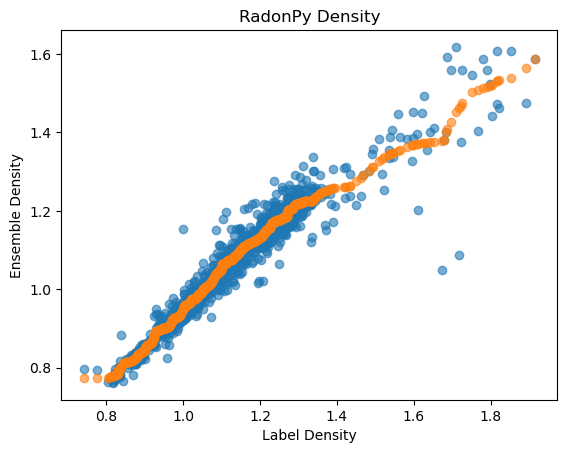

In [30]:
import matplotlib.pyplot as plt

TARGET_NAME = 'Density'

temp_df = (
    radonpy_labels_df
    .join(radonpy_predictions_df, on='SMILES', how='inner')
    .with_columns(
        pl.col('density').alias(f'{TARGET_NAME}_label'),
        pl.col(f'{TARGET_NAME}').alias(f'{TARGET_NAME}_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())
display(temp_df.describe())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/RadonPy.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'RadonPy {TARGET_NAME}')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

Baseline MAE: 3.728645861950844
Scaled MAE: 1.2627001603008507


SMILES,Rg_label,Rg_pred,Rg_rescaled_label
str,f64,f64,f64
"""*CC*""",22.52883,22.185518,20.912064
"""*C(C*)C""",18.304217,17.773364,16.782409
"""*C(C*)CC""",17.610296,14.541543,15.385807
"""*C(C*)CCC""",15.695795,12.563374,13.085192
"""*C(C*)C(C)C""",16.580243,13.116347,14.305557


statistic,SMILES,Rg_label,Rg_pred,Rg_rescaled_label
str,str,f64,f64,f64
"""count""","""1077""",1077.0,1077.0,1077.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,20.591548,17.235594,17.228662
"""std""",null,8.153136,4.445759,4.035282
"""min""","""*/C(=C/CC*)C""",10.366738,9.827004,10.221161
"""25%""",null,15.478508,12.949414,12.947675
"""50%""",null,19.35142,17.457206,18.568549
"""75%""",null,22.986085,20.942362,20.925917
"""max""","""*n1c(=O)c2cc3c(cc2c1=O)c(=O)n(…",85.684019,28.60161,27.563819


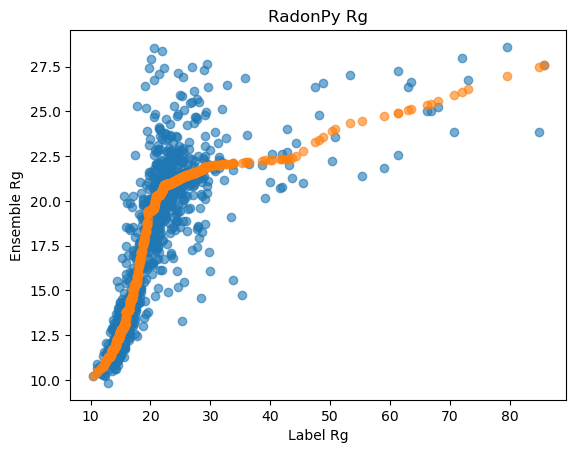

In [31]:
import matplotlib.pyplot as plt

TARGET_NAME = 'Rg'

temp_df = (
    radonpy_labels_df
    .join(radonpy_predictions_df, on='SMILES', how='inner')
    .with_columns(
        pl.col(TARGET_NAME).alias(f'{TARGET_NAME}_label'),
        pl.col(f'{TARGET_NAME}_right').alias(f'{TARGET_NAME}_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())
display(temp_df.describe())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/RadonPy.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'RadonPy {TARGET_NAME}')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

Baseline MAE: 0.030459256850264283
Scaled MAE: 0.023497839226776725


SMILES,Tc_label,Tc_pred,Tc_rescaled_label
str,f64,f64,f64
"""*C(C*)C""",0.258773,0.231105,0.236393
"""*C(C*)CC""",0.264363,0.222851,0.239186
"""*C(C*)CCC""",0.261131,0.224904,0.237038
"""*C(C*)C(C)C""",0.234342,0.19007,0.217503
"""*C(C*)CCCC""",0.275331,0.230052,0.250089


statistic,SMILES,Tc_label,Tc_pred,Tc_rescaled_label
str,str,f64,f64,f64
"""count""","""1047""",1047.0,1047.0,1047.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,0.234069,0.213879,0.213867
"""std""",null,0.053498,0.051225,0.041031
"""min""","""*/C(=C/CC*)C""",0.082201,0.084576,0.096349
"""25%""",null,0.205297,0.182667,0.19255
"""50%""",null,0.235508,0.212115,0.217964
"""75%""",null,0.26326,0.242703,0.237909
"""max""","""*n1c(=O)c2cc3c(cc2c1=O)c(=O)n(…",0.40124,0.402803,0.31737


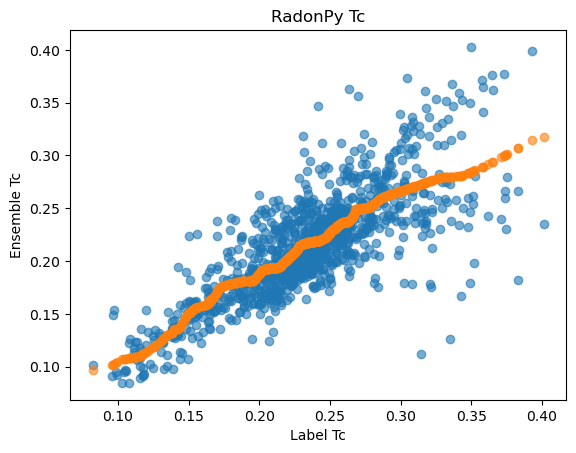

In [ ]:
import matplotlib.pyplot as plt

TARGET_NAME = 'Tc'

temp_df = (
    radonpy_labels_df
    .drop_nulls(subset='thermal_conductivity')
    .join(radonpy_predictions_df, on='SMILES', how='inner')
    .with_columns(
        pl.col('thermal_conductivity').alias(f'{TARGET_NAME}_label'),
        pl.col(f'{TARGET_NAME}').alias(f'{TARGET_NAME}_pred'),
    )
    .filter(pl.col(f'{TARGET_NAME}_label') < .402) # Experimental filtering!
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())
display(temp_df.describe())

# temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/RadonPy.csv')
temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/RadonPy_filtered.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'RadonPy {TARGET_NAME}')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

# Preprocess LAMALAB Tg data

In [50]:
lamalab_tg_labels_df = pl.from_pandas(pd.read_csv('../data/LAMALAB_CURATED_Tg_structured_polymerclass.csv'))
lamalab_tg_labels_df.head()

PSMILES,meta.polymer,SMILES,labels.Exp_Tg(K),meta.source,meta.tg_range,meta.tg_values,meta.num_of_points,meta.std,meta.reliability,sidechainlevel.features.num_atoms_sidechainfeaturizer_sum,sidechainlevel.features.num_atoms_sidechainfeaturizer_mean,sidechainlevel.features.num_atoms_sidechainfeaturizer_max,sidechainlevel.features.num_atoms_sidechainfeaturizer_min,sidechainlevel.features.numsidechainfeaturizer,sidechainlevel.features.sidechainlength_to_star_attachment_distance_ratio_mean,sidechainlevel.features.sidechainlength_to_star_attachment_distance_ratio_min,sidechainlevel.features.sidechainlength_to_star_attachment_distance_ratio_max,sidechainlevel.features.sidechainlength_to_star_attachment_distance_ratio_sum,sidechainlevel.features.star_to_sidechain_min_distance_mean,sidechainlevel.features.star_to_sidechain_min_distance_min,sidechainlevel.features.star_to_sidechain_min_distance_max,sidechainlevel.features.star_to_sidechain_min_distance_sum,sidechainlevel.features.num_diverse_sidechains,sidechainlevel.features.balaban_j_index_sidechainfeaturizer_sum,sidechainlevel.features.num_hbond_donors_sidechainfeaturizer_sum,sidechainlevel.features.num_hbond_acceptors_sidechainfeaturizer_sum,sidechainlevel.features.num_rotatable_bonds_sidechainfeaturizer_sum,sidechainlevel.features.num_rings_sidechainfeaturizer_sum,sidechainlevel.features.num_non_aromatic_rings_sidechainfeaturizer_sum,sidechainlevel.features.num_aromatic_rings_sidechainfeaturizer_sum,sidechainlevel.features.topological_surface_area_sidechainfeaturizer_sum,sidechainlevel.features.fraction_bicyclic_rings_sidechainfeaturizer_sum,sidechainlevel.features.num_aliphatic_heterocycles_sidechainfeaturizer_sum,sidechainlevel.features.slogp_vsa1_sidechainfeaturizer_sum,sidechainlevel.features.molecular_weight_sidechainfeaturizer_sum,sidechainlevel.features.sp3_carbon_count_sidechainfeaturizer_sum,…,backbonelevel.features.single_bonds_sum_backbonefeaturizer,backbonelevel.features.double_bonds_sum_backbonefeaturizer,backbonelevel.features.triple_bonds_sum_backbonefeaturizer,backbonelevel.features.bridging_rings_count_sum_backbonefeaturizer,backbonelevel.features.max_ring_size_sum_backbonefeaturizer,backbonelevel.features.heteroatom_density_sum_backbonefeaturizer,backbonelevel.features.heteroatom_count_sum_backbonefeaturizer,fullpolymerlevel.features.balaban_j_index_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_hbond_donors_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_hbond_acceptors_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_rotatable_bonds_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_rings_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_non_aromatic_rings_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_aromatic_rings_sum_fullpolymerfeaturizer,fullpolymerlevel.features.topological_surface_area_sum_fullpolymerfeaturizer,fullpolymerlevel.features.fraction_bicyclic_rings_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_aliphatic_heterocycles_sum_fullpolymerfeaturizer,fullpolymerlevel.features.slogp_vsa1_sum_fullpolymerfeaturizer,fullpolymerlevel.features.molecular_weight_sum_fullpolymerfeaturizer,fullpolymerlevel.features.sp3_carbon_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.sp2_carbon_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.max_estate_index_sum_fullpolymerfeaturizer,fullpolymerlevel.features.smr_vsa5_sum_fullpolymerfeaturizer,fullpolymerlevel.features.fp_density_morgan1_sum_fullpolymerfeaturizer,fullpolymerlevel.features.total_halogens_sum_fullpolymerfeaturizer,fullpolymerlevel.features.fluorine_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.chlorine_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.bromine_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.single_bonds_sum_fullpolymerfeaturizer,fullpolymerlevel.features.double_bonds_sum_fullpolymerfeaturizer,fullpolymerlevel.features.triple_bonds_sum_fullpolymerfeaturizer,fullpolymerlevel.features.bridging

In [52]:
lamalab_tg_preds_df = pl.from_pandas(pd.read_csv('relabeled_datasets/LAMALAB_CURATED_Tg_structured_polymerclass.csv'))
lamalab_tg_preds_df.head()

PSMILES,meta.polymer,SMILES,labels.Exp_Tg(K),meta.source,meta.tg_range,meta.tg_values,meta.num_of_points,meta.std,meta.reliability,sidechainlevel.features.num_atoms_sidechainfeaturizer_sum,sidechainlevel.features.num_atoms_sidechainfeaturizer_mean,sidechainlevel.features.num_atoms_sidechainfeaturizer_max,sidechainlevel.features.num_atoms_sidechainfeaturizer_min,sidechainlevel.features.numsidechainfeaturizer,sidechainlevel.features.sidechainlength_to_star_attachment_distance_ratio_mean,sidechainlevel.features.sidechainlength_to_star_attachment_distance_ratio_min,sidechainlevel.features.sidechainlength_to_star_attachment_distance_ratio_max,sidechainlevel.features.sidechainlength_to_star_attachment_distance_ratio_sum,sidechainlevel.features.star_to_sidechain_min_distance_mean,sidechainlevel.features.star_to_sidechain_min_distance_min,sidechainlevel.features.star_to_sidechain_min_distance_max,sidechainlevel.features.star_to_sidechain_min_distance_sum,sidechainlevel.features.num_diverse_sidechains,sidechainlevel.features.balaban_j_index_sidechainfeaturizer_sum,sidechainlevel.features.num_hbond_donors_sidechainfeaturizer_sum,sidechainlevel.features.num_hbond_acceptors_sidechainfeaturizer_sum,sidechainlevel.features.num_rotatable_bonds_sidechainfeaturizer_sum,sidechainlevel.features.num_rings_sidechainfeaturizer_sum,sidechainlevel.features.num_non_aromatic_rings_sidechainfeaturizer_sum,sidechainlevel.features.num_aromatic_rings_sidechainfeaturizer_sum,sidechainlevel.features.topological_surface_area_sidechainfeaturizer_sum,sidechainlevel.features.fraction_bicyclic_rings_sidechainfeaturizer_sum,sidechainlevel.features.num_aliphatic_heterocycles_sidechainfeaturizer_sum,sidechainlevel.features.slogp_vsa1_sidechainfeaturizer_sum,sidechainlevel.features.molecular_weight_sidechainfeaturizer_sum,sidechainlevel.features.sp3_carbon_count_sidechainfeaturizer_sum,…,backbonelevel.features.heteroatom_density_sum_backbonefeaturizer,backbonelevel.features.heteroatom_count_sum_backbonefeaturizer,fullpolymerlevel.features.balaban_j_index_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_hbond_donors_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_hbond_acceptors_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_rotatable_bonds_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_rings_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_non_aromatic_rings_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_aromatic_rings_sum_fullpolymerfeaturizer,fullpolymerlevel.features.topological_surface_area_sum_fullpolymerfeaturizer,fullpolymerlevel.features.fraction_bicyclic_rings_sum_fullpolymerfeaturizer,fullpolymerlevel.features.num_aliphatic_heterocycles_sum_fullpolymerfeaturizer,fullpolymerlevel.features.slogp_vsa1_sum_fullpolymerfeaturizer,fullpolymerlevel.features.molecular_weight_sum_fullpolymerfeaturizer,fullpolymerlevel.features.sp3_carbon_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.sp2_carbon_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.max_estate_index_sum_fullpolymerfeaturizer,fullpolymerlevel.features.smr_vsa5_sum_fullpolymerfeaturizer,fullpolymerlevel.features.fp_density_morgan1_sum_fullpolymerfeaturizer,fullpolymerlevel.features.total_halogens_sum_fullpolymerfeaturizer,fullpolymerlevel.features.fluorine_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.chlorine_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.bromine_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.single_bonds_sum_fullpolymerfeaturizer,fullpolymerlevel.features.double_bonds_sum_fullpolymerfeaturizer,fullpolymerlevel.features.triple_bonds_sum_fullpolymerfeaturizer,fullpolymerlevel.features.bridging_rings_count_sum_fullpolymerfeaturizer,fullpolymerlevel.features.max_ring_size_sum_fullpolymerfeaturizer,fullpolymerlevel.features.heteroatom_density_sum_fullpolymerfeaturizer,fullpolymerlevel.features.heteroatom_count_sum_fullpolymerfeaturizer,meta.polymer_class,raw_polymer_class,Tg,FFV,Tc,Density,Rg
s

Baseline MAE: 48.03982963098903
Scaled MAE: 35.84874364686145


SMILES,Tg_label,Tg_pred,Tg_rescaled_label
str,f64,f64,f64
"""*C#Cc1cccc(C#C[SiH2]*)c1""",72.0,84.951942,54.370111
"""*C#Cc1cccc(C#C[SiH](*)c2ccccc2…",85.0,115.143175,59.211633
"""*C#Cc1ccccc1C#C[SiH](*)c1ccccc…",71.0,120.959117,53.241429
"""*/C(=C(/*)c1ccc(C(C)(C)C)cc1)c…",200.0,168.653407,166.910136
"""*/C(=C(/*)c1ccc(CCCC)cc1)c1ccc…",200.0,107.731465,166.910136


statistic,SMILES,Tg_label,Tg_pred,Tg_rescaled_label
str,str,f64,f64,f64
"""count""","""7367""",7367.0,7367.0,7367.0
"""null_count""","""0""",0.0,0.0,0.0
"""mean""",null,143.912938,120.913656,121.087509
"""std""",null,112.70422,100.139791,87.431937
"""min""","""*/C(=C(/*)c1ccc(C(C)(C)C)cc1)c…",-139.0,-165.192331,-14.325995
"""25%""",null,55.0,39.465156,39.764484
"""50%""",null,137.0,96.851848,99.859304
"""75%""",null,234.0,196.815878,198.444765
"""max""","""[*]OC1=CC=C(C=C1)OC1=CC=C(C=C1…",495.0,434.900624,328.696143


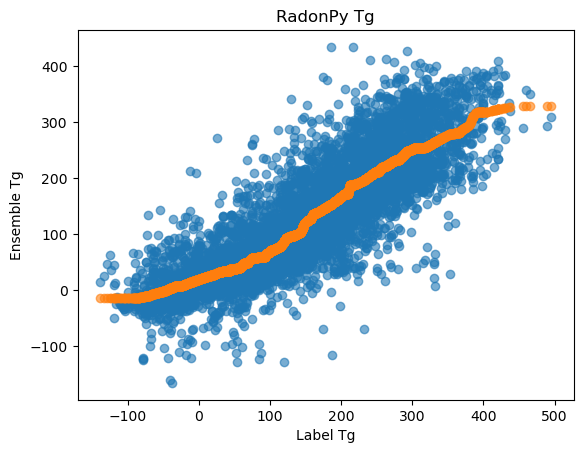

In [55]:
import matplotlib.pyplot as plt

TARGET_NAME = 'Tg'

temp_df = (
    lamalab_tg_labels_df
    .join(lamalab_tg_preds_df, on='SMILES', how='inner')
    .with_columns(
        (pl.col('labels.Exp_Tg(K)') - 273.15).alias(f'{TARGET_NAME}_label'),
        pl.col(f'{TARGET_NAME}').alias(f'{TARGET_NAME}_pred'),
    )
)['SMILES', f'{TARGET_NAME}_label', f'{TARGET_NAME}_pred']

print('Baseline MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_label']))

model = CenteredIsotonicRegression()
model.fit(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'])
rescaled_labels = model.predict(temp_df[f'{TARGET_NAME}_label'])
temp_df = temp_df.with_columns(**{f'{TARGET_NAME}_rescaled_label': rescaled_labels})

print('Scaled MAE:', mean_absolute_error(temp_df[f'{TARGET_NAME}_pred'], temp_df[f'{TARGET_NAME}_rescaled_label']))

display(temp_df.head())
display(temp_df.describe())

temp_df.write_csv(f'standardized_datasets/{TARGET_NAME}/LAMALAB.csv')

plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_pred'], alpha=0.6)
plt.scatter(temp_df[f'{TARGET_NAME}_label'], temp_df[f'{TARGET_NAME}_rescaled_label'], alpha=0.6)
plt.title(f'RadonPy {TARGET_NAME}')
plt.xlabel(f'Label {TARGET_NAME}')
plt.ylabel(f'Ensemble {TARGET_NAME}')
plt.show()

# Check for data leakage

In [90]:
from typing import Iterable, Sequence, List
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdFingerprintGenerator
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache

MORGAN_GEN = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

@lru_cache(100_000)
def smiles_to_morgan_fp(smiles_string: str, radius: int = 2, n_bits: int = 2048):
    molecule = Chem.MolFromSmiles(smiles_string)
    if molecule is None:
        return None
    return MORGAN_GEN.GetFingerprint(molecule)


def compute_max_tanimoto_per_test(
    training_smiles: Sequence[str],
    test_smiles: Sequence[str],
    radius: int = 2,
    n_bits: int = 2048,
) -> np.ndarray:
    training_fingerprints: List = [
        fp for fp in (smiles_to_morgan_fp(s, radius, n_bits) for s in training_smiles) if fp is not None
    ]
    if not training_fingerprints:
        raise ValueError("No valid training SMILES after RDKit parsing.")

    max_similarities: List[float] = []
    for test_string in test_smiles:
        test_fp = smiles_to_morgan_fp(test_string, radius, n_bits)
        if test_fp is None:
            max_similarities.append(np.nan)
            continue
        similarities = DataStructs.BulkTanimotoSimilarity(test_fp, training_fingerprints)
        max_similarities.append(max(similarities))

    return np.array(max_similarities, dtype=float)

def compute_max_tanimoto_per_train(
    train_smiles: Sequence[str],
    test_smiles: Sequence[str],
    radius: int = 2,
    n_bits: int = 2048,
) -> np.ndarray:
    test_fingerprints: List = [
        fp for fp in (smiles_to_morgan_fp(s, radius, n_bits) for s in test_smiles) if fp is not None
    ]
    if not test_fingerprints:
        raise ValueError("No valid test SMILES after RDKit parsing.")

    max_similarities: List[float] = []
    for train_string in train_smiles:
        train_fp = smiles_to_morgan_fp(train_string, radius, n_bits)
        if train_fp is None:
            max_similarities.append(np.nan)
            continue
        similarities = DataStructs.BulkTanimotoSimilarity(train_fp, test_fingerprints)
        max_similarities.append(max(similarities))

    return np.array(max_similarities, dtype=float)

def plot_similarity_histogram(similarities: Iterable[float], title, bin_count=20):
    similarities = np.asarray(similarities, dtype=float)
    similarities = similarities[~np.isnan(similarities)]
    plt.figure()
    plt.hist(similarities, bins=bin_count)
    plt.xlabel("Max Tanimoto similarity to any training molecule")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_overlaid_histograms(
    name_to_scores: dict[str, Iterable[float]],
    bin_count: int = 30,
    range_: tuple[float, float] = (0.0, 1.0),
    density: bool = False,
):
    """
    Overlay histograms for multiple similarity arrays on a single figure.
    Uses identical bin edges so curves line up.
    """
    cleaned = {
        name: np.asarray(scores, dtype=float)[~np.isnan(scores)]
        for name, scores in name_to_scores.items()
    }

    bin_edges = np.linspace(range_[0], range_[1], bin_count + 1)

    plt.figure()
    for name, arr in cleaned.items():
        if not density:
            plt.hist(arr, label=name, bins=bin_count, alpha=0.6)
        else:
            hist, _ = np.histogram(arr, bins=bin_edges, density=density)
            # Plot as a step so overlaps are clearer
            centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            plt.step(centers, hist, where="mid", label=name, linewidth=1.8, alpha=0.9)


    plt.xlabel("Max Tanimoto similarity to any training molecule")
    plt.ylabel("Density" if density else "Count")
    plt.title("Train–Test Max Tanimoto Similarity Distributions")
    plt.legend()
    plt.tight_layout()
    plt.show()

0.022940138455273516
0.00980392156862745


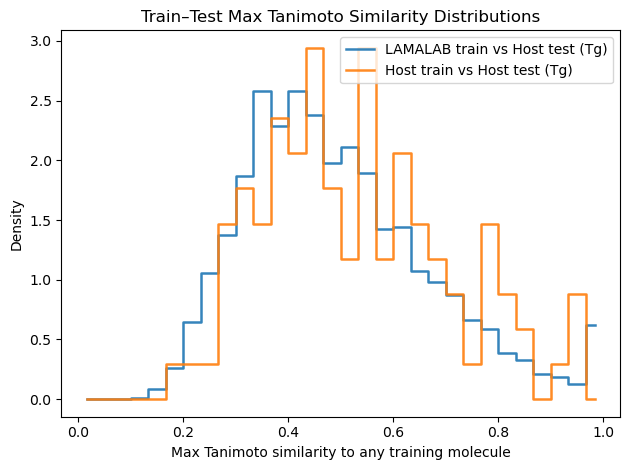

In [119]:
from sklearn.model_selection import train_test_split

host_smiles = pl.read_csv('../data/from_host/train.csv').drop_nulls(subset='Tg')['SMILES']
train_smiles, test_smiles = train_test_split(host_smiles, test_size=0.8)

extra_train_smiles = pl.read_csv('standardized_datasets/Tg/LAMALAB.csv')['SMILES']

# extra_vs_host = compute_max_tanimoto_per_test(extra_train_smiles, test_smiles)
# host_vs_host = compute_max_tanimoto_per_test(train_smiles, test_smiles)

extra_vs_host = compute_max_tanimoto_per_train(extra_train_smiles, test_smiles)
host_vs_host = compute_max_tanimoto_per_train(train_smiles, test_smiles)

print(sum(extra_vs_host > 0.95) / len(extra_vs_host))
print(sum(host_vs_host > 0.95) / len(host_vs_host))

plot_overlaid_histograms(
    {
        "LAMALAB train vs Host test (Tg)": extra_vs_host,
        "Host train vs Host test (Tg)": host_vs_host,
    },
    bin_count=30,
    density=True,  # flip to True if you want areas normalized
)

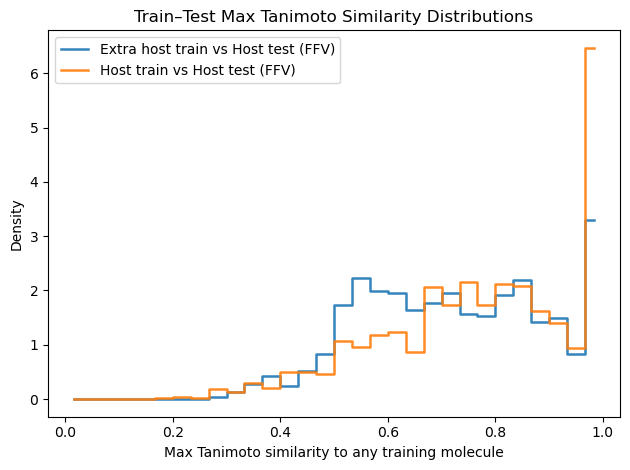

In [93]:
host_smiles = pl.read_csv('../data/from_host/train.csv').drop_nulls(subset='FFV')['SMILES']
train_smiles, test_smiles = train_test_split(host_smiles, test_size=0.8)

extra_train_smiles = pl.read_csv('standardized_datasets/FFV/host_extra.csv')['SMILES']

# extra_vs_host = compute_max_tanimoto_per_test(extra_train_smiles, test_smiles)
# host_vs_host = compute_max_tanimoto_per_test(train_smiles, test_smiles)
extra_vs_host = compute_max_tanimoto_per_train(extra_train_smiles, test_smiles)
host_vs_host = compute_max_tanimoto_per_train(train_smiles, test_smiles)

plot_overlaid_histograms(
    {
        "Extra host train vs Host test (FFV)": extra_vs_host,
        "Host train vs Host test (FFV)": host_vs_host,
    },
    bin_count=30,
    density=True,  # flip to True if you want areas normalized
)

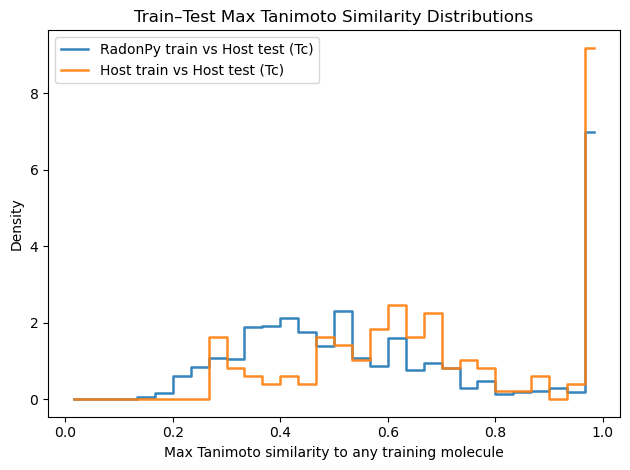

In [94]:
host_smiles = pl.read_csv('../data/from_host/train.csv').drop_nulls(subset='Tc')['SMILES']
train_smiles, test_smiles = train_test_split(host_smiles, test_size=0.8)

extra_train_smiles = pl.read_csv('standardized_datasets/Tc/RadonPy.csv')['SMILES']

# extra_vs_host = compute_max_tanimoto_per_test(extra_train_smiles, test_smiles)
# host_vs_host = compute_max_tanimoto_per_test(train_smiles, test_smiles)
extra_vs_host = compute_max_tanimoto_per_train(extra_train_smiles, test_smiles)
host_vs_host = compute_max_tanimoto_per_train(train_smiles, test_smiles)

plot_overlaid_histograms(
    {
        "RadonPy train vs Host test (Tc)": extra_vs_host,
        "Host train vs Host test (Tc)": host_vs_host,
    },
    bin_count=30,
    density=True,  # flip to True if you want areas normalized
)

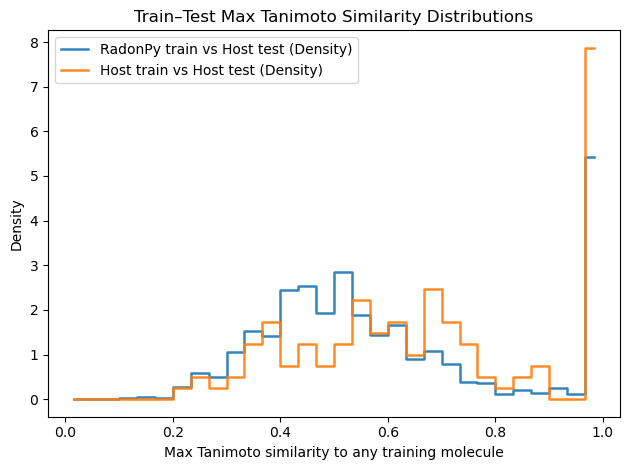

In [95]:
host_smiles = pl.read_csv('../data/from_host/train.csv').drop_nulls(subset='Density')['SMILES']
train_smiles, test_smiles = train_test_split(host_smiles, test_size=0.8)

extra_train_smiles = pl.read_csv('standardized_datasets/Density/RadonPy.csv')['SMILES']

# extra_vs_host = compute_max_tanimoto_per_test(extra_train_smiles, test_smiles)
# host_vs_host = compute_max_tanimoto_per_test(train_smiles, test_smiles)
extra_vs_host = compute_max_tanimoto_per_train(extra_train_smiles, test_smiles)
host_vs_host = compute_max_tanimoto_per_train(train_smiles, test_smiles)

plot_overlaid_histograms(
    {
        "RadonPy train vs Host test (Density)": extra_vs_host,
        "Host train vs Host test (Density)": host_vs_host,
    },
    bin_count=30,
    density=True,  # flip to True if you want areas normalized
)

0.0777262180974478
0.17780938833570412


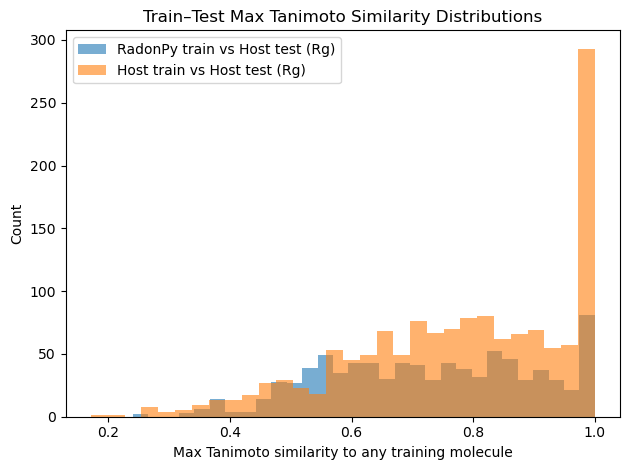

In [ ]:
def canonicalize_smiles(smiles: str) -> str:
    molecule = Chem.MolFromSmiles(smiles)
    return Chem.MolToSmiles(molecule, canonical=True) if molecule is not None else None

host_df = pl.read_csv('../data/from_host/train.csv').drop_nulls(subset='Rg')
host_smiles = host_df.to_pandas()['SMILES'].map(canonicalize_smiles)
host_smiles = host_smiles.unique()
train_smiles, test_smiles = train_test_split(host_smiles, test_size=0.8, random_state=0)

extra_df = pl.read_csv('standardized_datasets/Rg/RadonPy.csv').to_pandas()
extra_df['SMILES'] = extra_df['SMILES'].map(canonicalize_smiles)
extra_df = extra_df[~extra_df['SMILES'].isin(host_smiles)]
extra_train_smiles = pl.from_pandas(extra_df['SMILES'])

# extra_vs_host = compute_max_tanimoto_per_test(extra_train_smiles, test_smiles)
# host_vs_host = compute_max_tanimoto_per_test(train_smiles, test_smiles)
extra_vs_host = compute_max_tanimoto_per_train(extra_train_smiles, test_smiles)
host_vs_host = compute_max_tanimoto_per_train(train_smiles, test_smiles)

print(sum(extra_vs_host == 1) / len(extra_vs_host))
print(sum(host_vs_host == 1) / len(host_vs_host))

plot_overlaid_histograms(
    {
        "RadonPy train vs Host test (Rg)": extra_vs_host,
        "Host train vs Host test (Rg)": host_vs_host,
    },
    bin_count=30,
    density=False,  # flip to True if you want areas normalized
)

# Check label correlation for near duplicates

In [257]:
import hashlib

def get_morgan_hash(smiles):
    morgan_fp_bits = smiles_to_morgan_fp(smiles)
    morgan_hash = hashlib.md5(''.join([f'{b}' for b in morgan_fp_bits]).encode('utf8')).hexdigest()
    return morgan_hash

host_df = pd.read_csv('../data/from_host/train.csv').dropna(subset='Rg')

extra_df = pd.read_csv('standardized_datasets/Rg/RadonPy.csv')
# extra_df = extra_df[~extra_df['SMILES'].isin(host_df['SMILES'])]

host_df['smiles_hash'] = host_df['SMILES'].map(get_morgan_hash)
extra_df['smiles_hash'] = extra_df['SMILES'].map(get_morgan_hash)

host_df = pl.DataFrame(host_df)
extra_df = pl.DataFrame(extra_df)

extra_df.head()

SMILES,Rg_label,Rg_pred,Rg_rescaled_label,smiles_hash
str,f64,f64,f64,str
"""*CC*""",22.52883,22.185518,20.912064,"""c6c8316494a7156b615a7f719ff3c4…"
"""*C(C*)C""",18.304217,17.773364,16.782409,"""b96ff48f4e5337f3974c2f12ed0f49…"
"""*C(C*)CC""",17.610296,14.541543,15.385807,"""f2a53bafebced288993c6c80802d80…"
"""*C(C*)CCC""",15.695795,12.563374,13.085192,"""c627c8499f845a25e9db2d071a4f07…"
"""*C(C*)C(C)C""",16.580243,13.116347,14.305557,"""273f0917d209d59b9a832097c71209…"


In [271]:
joined_df = host_df.join(extra_df, on='smiles_hash')
# joined_df = host_df.join(extra_df, on='SMILES')
# joined_df = host_df.join(host_df, on='smiles_hash')
# joined_df = joined_df.filter(joined_df['SMILES'] != joined_df['SMILES_right'])
joined_df = joined_df.sort(by='smiles_hash')
joined_df.head()

id,SMILES,Tg,FFV,Tc,Density,Rg,smiles_hash,SMILES_right,Rg_label,Rg_pred,Rg_rescaled_label
i64,str,f64,f64,f64,f64,f64,str,str,f64,f64,f64
364982310,"""*CC(*)c1ccc(C(=O)OC)cc1""",null,null,0.203333,1.032355,13.103796,"""0172b589a2fc687dfc2d74848b4d25…","""*C(C*)c1ccc(cc1)C(=O)OC""",15.117304,13.617206,12.779128
190407869,"""*CC(*)O""",null,null,0.424,1.081207,22.519883,"""023231fe14f751e73537d58a14ae62…","""*C(C*)O""",22.626903,20.91637,20.915035
64606581,"""*CC1CCC(*)C1""",42.359315,null,0.335333,0.892957,21.777944,"""05280ed74d2fa7eda55fb57eb01ee9…","""*C1CC(CC1)C*""",24.210587,18.829567,21.125962
1677600893,"""*Oc1ccc(C(C)(C)c2ccc(OC(=O)c3c…",null,0.360825,null,1.104373,25.54111,"""069415d056eaccb70ba91943b229aa…","""*Oc1ccc(cc1)C(c1ccc(cc1)OC(=O)…",25.57932,22.699463,21.371367
394096295,"""*CC(*)OC(C)C""",null,null,0.2115,0.8398,13.443085,"""099a3f7a8c2bbd07f6ea54097114bf…","""*C(C*)OC(C)C""",16.302063,13.542048,13.875691


In [164]:
# mean_absolute_error(joined_df['Rg'], joined_df['Rg_right'])

In [260]:
mean_absolute_error(joined_df['Rg'], joined_df['Rg_label'])

2.030106230002472

In [263]:
scaled_label_weight = 1
mean_absolute_error(
    joined_df['Rg'], 
    (scaled_label_weight * joined_df['Rg_rescaled_label']) + ((1 - scaled_label_weight)*joined_df['Rg_label'])
)

1.419553524923823

In [269]:
scaled_label_weight = 0
mean_absolute_error(
    joined_df['Rg'], 
    (scaled_label_weight * joined_df['Rg_rescaled_label']) + ((1 - scaled_label_weight)*joined_df['Rg_pred'])
)

1.1418667229686954